In [1]:
#Generates a random SAW of a given length by repeatedly choosing the next step and checking for validity, starting at (0,0,0)
#Returns step array, coordinate array, and set of all points on the SAW.
function genRandWalk(len)
    dirs = []
    coordArr = [(0,0,0)]
    coordSet = Set(((0,0,0),))
    pNext = (0,0,0)
    pLast = (0,0,0)

    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))    #1:+x, 2:-x, 3:+y, 4:-y, 5:+z, 6:-z
    i = 0
    while i<len
        r = rand((1,2,3,4,5,6))

        pNext=(pLast[1],pLast[2],pLast[3])

        pNext = pNext .+ dLookup[r]

        if(!(pNext in coordSet))    #Check for self-intersection
            push!(dirs,r)
            push!(coordArr,pNext)
            union!(coordSet,(pNext,))
            pLast=pNext
            i+=1
        end

    end
    
    return dirs,coordArr,coordSet

end

#Generates a completely straight SAW of a given length, starting at (0,0,0) and extending in the +z direction
function genStrWalk(len)
    dirs = fill(5,len)
    coordArr = [(0,0,0),]
    coordSet = Set(((0,0,0),))
    for i = 1:len
        push!(coordArr,(0,0,i))
        union!(coordSet,((0,0,i),))
    end
        
    return dirs,coordArr,coordSet
end

genStrWalk (generic function with 1 method)

In [2]:
#Basic midpoint calculator, for energy calculations
function midpoint(p1,p2)
    x=(p1[1]+p2[1])/2
    y=(p1[2]+p2[2])/2
    z=(p1[3]+p2[3])/2
    return (x,y,z)
end

#Basic distance calculator, for energy calculations and adjacency-testing
function distance(p1,p2)
    return sqrt((p1[1]-p2[1])^2+(p1[2]-p2[2])^2+(p1[3]-p2[3])^2)
end

distance (generic function with 1 method)

In [3]:
#Calculate the total energy of the SAW (as a vortex)
function energySum(dirs,coordArr)
    sum = 0
    dirSort = [[],[],[],[],[],[]]    #Sort segments (midpoints) by direction
    for i = 1:length(dirs)
        push!(dirSort[dirs[i]],midpoint(coordArr[i],coordArr[i+1]))
    end
    
    for i in dirSort[1]
        for j in setdiff(dirSort[1],(i,))
            sum+=(1/distance(i,j))    #Same directions contribute positively
        end
        for j in dirSort[2]
            sum-=(1/distance(i,j))    #Reverse directions contribute negatively
        end
    end
    for i in dirSort[2]
        for j in setdiff(dirSort[2],(i,))
            sum+=(1/distance(i,j))
        end
        for j in dirSort[1]
            sum-=(1/distance(i,j))
        end
    end
    for i in dirSort[3]
        for j in setdiff(dirSort[3],(i,))
            sum+=(1/distance(i,j))
        end
        for j in dirSort[4]
            sum-=(1/distance(i,j))
        end
    end
    for i in dirSort[4]
        for j in setdiff(dirSort[4],(i,))
            sum+=(1/distance(i,j))
        end
        for j in dirSort[3]
            sum-=(1/distance(i,j))
        end
    end
    for i in dirSort[5]
        for j in setdiff(dirSort[5],(i,))
            sum+=(1/distance(i,j))
        end
        for j in dirSort[6]
            sum-=(1/distance(i,j))
        end
    end
    for i in dirSort[6]
        for j in setdiff(dirSort[6],(i,))
            sum+=(1/distance(i,j))
        end
        for j in dirSort[5]
            sum-=(1/distance(i,j))
        end
    end
    return sum/(8*pi)
end

#Old version - shorter computation time for shorter/straighter configurations
function energySumAlt(dirs,coordArr)
    sum = 0
    for i = 1:length(dirs)
        p1Mid = midpoint(coordArr[i],coordArr[i+1])
        p1Sum = 0
        d1 = dirs[i]
        for j = setdiff(1:length(dirs),(i,))    #Every index not equal to i
            d2 = dirs[j]
            if issubset((d1,d2),(1,2))||issubset((d1,d2),(3,4))||issubset((d1,d2),(5,6))    #Is same or opposite direction
                p2Mid=midpoint(coordArr[j],coordArr[j+1])
                if d1==d2
                    p1Sum+=(1/distance(p1Mid,p2Mid))    #Same directions contribute positively
                else
                    p1Sum-=(1/distance(p1Mid,p2Mid))    #Opposite directions contribute negatively
                end
            end
        end
        sum+=p1Sum
    end
    return sum/(8*pi)
end

energySumAlt (generic function with 1 method)

In [4]:
#Generate the array (and set) of points from the array of steps (recalibrates at (0,0,0))
function dirToCoords(dirs)
    coordArr = [(0,0,0)]
    coordSet = Set(((0,0,0),))
    p = (0,0,0)
    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))
    for d in dirs
        p = p .+ dLookup[d]
        push!(coordArr,p)
        union!(coordSet,(p,))
    end
    return coordArr, coordSet
end

#Generate the array of steps from the array of points
function coordsToDir(coordArr)
    dirs = []
    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))
    for i = 2:length(coordArr)
        p1 = coordArr[i-1]
        p2 = coordArr[i]
        disp = p2 .- p1
        
        for d = 1:6
            if disp==dLookup[d]
                push!(dirs,d)
                break
            end
        end
    end
    return dirs
end

coordsToDir (generic function with 1 method)

In [5]:
#Makes a particular interior pull move (mutates coordArr and coordSet)
#index : the point to "be pulled" (originate the move)
#dispDir : 1 for "towards the end", -1 for "towards the origin"
#displace : relative location for the index point to end up
function pull!(coordArr,coordSet,index,dispDir,displace)
    p1 = coordArr[index]
    dest = p1 .+ displace
    
    if dest in coordSet    #Self-intersection check
        return false
    end
    
    p0 = coordArr[index+dispDir]
    p2 = coordArr[index-dispDir]
    bypoints = [p1 .+ (displace[1],0,0),p1 .+ (0,displace[2],0),p1 .+ (0,0,displace[3])]    #Candidates for p2 to end up; one will necessaily be p0 and one p1
    setdiff!(bypoints,[p1,p0])
    pBy = bypoints[1]
    if pBy==p2
        coordArr[index]=dest    #Single-point move
        setdiff!(coordSet,[p1])
        union!(coordSet,(dest,))
        return true
    else
        if pBy in coordSet    #Self-intersection check #2
            return false
        end
        union!(coordSet,(dest,pBy))    #Validity is ensured, add new points to set
        if dispDir==-1
            insert!(coordArr,index,pBy)
            insert!(coordArr,index,dest)
            for i = (index+1):(length(coordArr)-3)
                if distance(coordArr[i],coordArr[i+3])==1
                    setdiff!(coordSet,[coordArr[i+1],coordArr[i+2]])    #If move can terminate before end, do so
                    deleteat!(coordArr,i+2)
                    deleteat!(coordArr,i+1)
                    return true
                end
            end
            setdiff!(coordSet,[pop!(coordArr),pop!(coordArr)])    #If no place to terminate move, it goes all the way to the end
            return true
        elseif dispDir==1
            insert!(coordArr,index+1,dest)
            insert!(coordArr,index+1,pBy)
            for i = (index+1):-1:4
                if distance(coordArr[i],coordArr[i-3])==1
                    setdiff!(coordSet,[coordArr[i-1],coordArr[i-2]])    #If move can terminate before end, do so
                    deleteat!(coordArr,i-1)
                    deleteat!(coordArr,i-2)
                    return true
                end
            end
            setdiff!(coordSet,[popfirst!(coordArr),popfirst!(coordArr)])    #If no place to end move, it goes all the way to the end
            return true
        end
    end 
end

#Makes a particular end-pull move (mutates coordArr and coordSet)
#index : the point to "be pulled" (originate the move)
#dispBy : relative location for the endpoint to be pulled "through"
#dispDest : relative location for the endpoint to end up
function pullEnd!(coordArr,coordSet,index,dispBy,dispDest)
    p1 = coordArr[index]
    pBy = p1 .+ dispBy
    dest = p1 .+ dispDest
    
    if (dest in coordSet)||(pBy in coordSet)    #Self-intersection check
        return false
    end

    union!(coordSet,(dest,pBy))    #Validity is ensured, add new points to set
    if index==1
        insert!(coordArr,1,pBy)
        insert!(coordArr,1,dest)
        for i = (index+1):(length(coordArr)-3)
            if distance(coordArr[i],coordArr[i+3])==1
                setdiff!(coordSet,[coordArr[i+1],coordArr[i+2]])    #If move can terminate before end, do so
                deleteat!(coordArr,i+2)
                deleteat!(coordArr,i+1)
                return true
            end
        end
        setdiff!(coordSet,[pop!(coordArr),pop!(coordArr)])    #If no place to end move, it goes all the way to the end
        return true
    elseif index==length(coordArr)
        insert!(coordArr,index+1,dest)
        insert!(coordArr,index+1,pBy)
        for i = (index+1):-1:4
            if distance(coordArr[i],coordArr[i-3])==1
                setdiff!(coordSet,[coordArr[i-1],coordArr[i-2]])    #If move can terminate before end, do so
                deleteat!(coordArr,i-1)
                deleteat!(coordArr,i-2)
                return true
            end
        end
        setdiff!(coordSet,[popfirst!(coordArr),popfirst!(coordArr)])    #If no place to end move, it goes all the way to the end
        return true
    end 
end

pullEnd! (generic function with 1 method)

In [6]:
using Random

#β = 1    #"Inverse temperature"     don't make global when multi-threading

#Attempts a single pull move (mutates parameters)
#Returns 1 for success, 2 for invalid, 3 for rejected (latter two leave params unchanged)
#eLast - current configuration's energy (avoiding redundant calculations)
function attemptAPull!(coordArr,coordSet,dirs,β,eLast)
    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))
    rev = (2,1,4,3,6,5)    #Reference to find the reverse direction
    testArr = copy(coordArr)
    testSet = copy(coordSet)
    testDir = []
    eNext = eLast
    index = rand(1:length(coordArr))    #Find random point
    if index==1
        dirBy = rand(setdiff(1:6,(dirs[1],)))
        dispDest = dLookup[dirBy] .+ dLookup[rand(setdiff(1:6,(rev[dirBy],dirs[1])))]    #second step cannot undo first nor be a hook move
        #println("$(index) displaced by $(dispDest) via $(dLookup[dirBy])")
        if !pullEnd!(testArr,testSet,1,dLookup[dirBy],dispDest)
            return 2,eNext   #Return 2 for self-intersection-failure
        end
        testDir = coordsToDir(testArr)
        probMod = 1.0
        if testArr[end]==coordArr[end]    #Did not propagate through; was this the same direction or new?
            if dirBy==rev[dirs[1]]
                probMod = 3.125
            else
                probMod = 2.5
            end
        elseif ((coordArr[end-1] .- testArr[end])==dLookup[testDir[end]])&&(dirBy!=rev[dirs[1]])    #Did reach other end - was there still imbalance?
            probMod = 0.8
        elseif ((coordArr[end-1] .- testArr[end])!=dLookup[testDir[end]])&&(dirBy==rev[dirs[1]])
            probMod = 1.25
        end
        eNext = energySum(testDir,testArr)
        prob = min(1,probMod*ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE)*[probability modifier])
        if rand()>prob
            return 3,eNext    #Return 3 for rejection-failure
        end
    elseif index==length(coordArr)
        dirBy = rand(setdiff(1:6,(rev[dirs[end]],)))
        dispDest = dLookup[dirBy] .+ dLookup[rand(setdiff(1:6,(rev[dirBy],rev[dirs[end]])))]    #second step cannot undo first nor be a hook move
        #println("$(index) displaced by $(dispDest) via $(dLookup[dirBy])")
        if !pullEnd!(testArr,testSet,index,dLookup[dirBy],dispDest)
            return 2,eNext    #Return 2 for self-intersection-failure
        end
        testDir = coordsToDir(testArr)
        probMod = 1.0
        if testArr[1]==coordArr[1]    #Did not propagate through; was this the same direction or new?
            if dirBy==rev[dirs[end]]
                probMod = 3.125
            else
                probMod = 2.5
            end
        elseif ((testArr[1] .- coordArr[2])==dLookup[testDir[1]])&&(dirBy!=dirs[end])    #Did reach other end - was there still imbalance?
            probMod = 0.8
        elseif ((testArr[1] .- coordArr[2])!=dLookup[testDir[1]])&&(dirBy==dirs[end])
            probMod = 1.25
        end
        eNext = energySum(testDir,testArr)
        prob = min(1,probMod*ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE)*[probability modifier])
        if rand()>prob
            return 3,eNext    #Return 3 for rejection-failure
        end
    else
        dispDir = rand((1,-1))
        if dispDir==-1
            displace = dLookup[rand(setdiff(1:6,(dirs[index-1],rev[dirs[index-1]])))] .+ dLookup[rev[dirs[index-1]]]    #Pick vector orthogonal to (previous) step
        else
            displace = dLookup[rand(setdiff(1:6,(dirs[index],rev[dirs[index]])))] .+ dLookup[dirs[index]]
        end
        #println("$(index) displaced by $(displace) towards $((dispDir==1) ? "p11" : "p1")")
        if !pull!(testArr,testSet,index,dispDir,displace)
            return 2,eNext    #Return 2 for self-intersection-failure
        end
        testDir = coordsToDir(testArr)
        probMod = 1.0
        if (testArr[1]!=coordArr[1])||(testArr[end]!=coordArr[end])    #Did it move either end? If so, would it need to go back the same direction? 
            if ((testArr[1] .- coordArr[2])==dLookup[testDir[1]])||((coordArr[end-1] .- testArr[end])==dLookup[testDir[end]])
                probMod = 0.32
            else
                probMod = 0.40
            end
        end
        eNext = energySum(testDir,testArr)
        prob = min(1,probMod*ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE)*[probability modifier])
        if rand()>prob
            return 3,eNext    #Return 3 for rejection-failure
        end
    end
    splice!(coordArr,1:length(coordArr),testArr)    #Confirm changes by mutating inputs; return 1 for success
    splice!(dirs,1:length(dirs),testDir)
    intersect!(coordSet,testSet)
    union!(coordSet,testSet)
    return 1,eNext
end

#Makes a single pull move - will always return distinct state (may be congruent)
function makeAPull!(coordArr,coordSet,dirs,β)
    while true
        if attemptAPull!(coordArr,coordSet,dirs,β,energySum(dirs,coordArr))[1]==1
            return nothing
        end
    end
end

makeAPull! (generic function with 1 method)

In [7]:
#Determines if a rebridge move is possible, where it would connect, and the alignment between the adjacent segments
#index : point on the SAW for move to "originate" such that index and index+1 will be connected to their neighbors
#moveDir : direction from index for bond to be created
function rebridgeFindVertices(coordArr,coordSet,dirs,index,moveDir)
    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))
    rev = (2,1,4,3,6,5)    #Reference to find the reverse direction
    if ((coordArr[index] .+ dLookup[moveDir]) ∉ coordSet)||((coordArr[index+1] .+ dLookup[moveDir]) ∉ coordSet)||((index!=1)&&(dirs[index-1]==rev[moveDir]))||((index!=length(dirs))&&(dirs[index+1]==moveDir))
        return 0,index    #Failed first validity checks
    end
    for i = 1:(length(coordArr))
        if coordArr[i]==(coordArr[index] .+ dLookup[moveDir])    #Find point adjacent to index and determine relation to point adjacent to index+1
            if (i>1)&&(dirs[i-1]==rev[dirs[index]])
                return 2,i
            elseif (i<length(coordArr))&&(dirs[i]==dirs[index])
                return 1,i
            else
                return 0,index
            end
        end
    end
    return 0,index
end

#Determines if the second step of a two-step rebridge is possible, where it would connect, and relative alignment
#loop,coordArr : the spliced "loop" portion of the SAW and the remaining SAW, respectively
#jndex : point on the loop for move to originate
#moveDir : direction from jndex for bond to be created
function rebridgeFindVertices2(coordArr,coordSet,loop,jndex,moveDir)
    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))
    rev = (2,1,4,3,6,5)    #Reference to find the reverse direction
    dirs = coordsToDir(coordArr)
    loop = push!(copy(loop),loop[1])
    loopDirs = coordsToDir(loop)
    if ((loop[jndex] .+ dLookup[moveDir]) ∉ coordSet)||((loop[jndex+1] .+ dLookup[moveDir]) ∉ coordSet)||((jndex!=1)&&(loopDirs[jndex-1]==rev[moveDir]))||((jndex!=length(loopDirs))&&(loopDirs[jndex+1]==moveDir))
        return 0,jndex    #Failed first validity checks
    end
    for i = 1:(length(coordArr))
        if coordArr[i]==(loop[jndex] .+ dLookup[moveDir])    #Find point adjacent to jndex and determine relation to point adjacent to jndex+1
            if (i>1)&&(dirs[i-1]==rev[loopDirs[jndex]])
                return 2,i
            elseif (i<length(coordArr))&&(dirs[i]==loopDirs[jndex])
                return 1,i
            else
                return 0,jndex
            end
        end
    end
    return 0,jndex
end

#Makes a particular single-step rebridging move (mutates coordArr)
#index1, index2: the points to be connected, such that index1+1 and index2+1 are also connected
function rebridge1Step!(coordArr,index1,index2)
    i1 = min(index1,index2)
    i2 = max(index1,index2)
    splice!(coordArr,(i1+1):i2,reverse(coordArr[(i1+1):i2]))
    return nothing
end

#Makes a particular double-step rebridging move (mutates coordArr)
#index1, index2 : the first points to be connected, such that index1+1 and index2+1 are also connected
#jndex : point which will be on the loop for second stage to originate
#moveDir : direction from jndex for second bond to be created
function rebridge2Step!(coordArr,coordSet,index1,index2,jndex2,moveDir)
    if index1>index2
        i1 = index2-1
        i2 = index1+1
    else
        i1 = index1
        i2 = index2
    end
    jndex2-=index1
    loop = splice!(coordArr,(i1+1):(i2-1))    #First stage
    jalign,jndex1 = rebridgeFindVertices2(coordArr,coordSet,loop,jndex2,moveDir)
    if jalign==0
        return false    #Second step invalid, cancel entire move
    end
    
    if jalign==1
        pj2 = loop[jndex2]    #Parallel segments means loop must be reversed
        reverse!(loop)
    else
        jndex1-=1
        if jndex2==length(loop)    #Anti-parallel segments require slight difference in re-splicing location
            pj2 = loop[1]
        else
            pj2 = loop[jndex2+1]
        end
    end
    while(loop[1]!=pj2)
        push!(loop,popfirst!(loop))    #Permute loop until it is in correct position to re-splice
    end
    splice!(coordArr,(jndex1+1):jndex1,loop)
    
    return true
end

#Makes a particular end-rebridging move (mutates coordArr)
#index : the start/end point
#disp : the direction from index for the bond to be created
function rebridgeEnd!(coordArr,coordSet,index,disp)
    if (coordArr[index] .+ disp) ∉ coordSet
        return false    #Only fails if connection point not on SAW
    end
    i2 = index
    for i = 1:(length(coordArr))
        if coordArr[i]==(coordArr[index] .+ disp)
            if index==1
                splice!(coordArr,1:(i-1),reverse(coordArr[1:(i-1)]))
            else
                splice!(coordArr,i+1:index,reverse(coordArr[(i+1):end]))
            end
            return true
        end
    end
    return false    #Dummy return, should not trigger
end

rebridgeEnd! (generic function with 1 method)

In [8]:
#Attempts a single rebridge move (mutates parameters)
#Returns 1 for success, 2 for invalid, 3 for rejected (latter two leave params unchanged)
function attemptARebridge!(coordArr,coordSet,dirs,β,eLast)
    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))
    rev = (2,1,4,3,6,5)    #Reference to find the reverse direction
    testArr = copy(coordArr)
    testDir = copy(dirs)
    eNext = eLast
    index1 = rand(0:length(coordArr))    #Find random point
    if index1==0
        d = rand(setdiff(1:6,(dirs[1],)))
        if !rebridgeEnd!(testArr,coordSet,1,dLookup[d])
            return 2,eNext    #Return 2 for invalid move
        end
        testDir = coordsToDir(testArr)
        eNext = energySum(testDir,testArr)
        prob = min(1,ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE))
        if rand()>prob
            return 3,eNext    #Return 3 for rejection-failure
        end
    elseif index1==length(coordArr)
        d = rand(setdiff(1:6,(rev[dirs[end]],)))
        if !rebridgeEnd!(testArr,coordSet,index1,dLookup[d])
            return 2,eNext    #Return 2 for invalid move
        end
        testDir = coordsToDir(testArr)
        eNext = energySum(testDir,testArr)
        prob = min(1,ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE))
        if rand()>prob
            return 3,eNext    #Return 3 for rejection-failure
        end
    else
        d = rand(setdiff(1:6,(dirs[index1],rev[dirs[index1]])))
        steps,index2 = rebridgeFindVertices(coordArr,coordSet,dirs,index1,d)
        #println(index1,d)
        if steps==0
            return 2,eNext    #Return 2 for invalid move
        elseif steps==1
            rebridge1Step!(testArr,index1,index2)
            testDir = coordsToDir(testArr)
            eNext = energySum(testDir,testArr)
            prob = min(1,ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE))
            if rand()>prob
                return 3,eNext    #Return 3 for rejection-failure
            end
        elseif steps==2
            if(index1>index2)
                index1,index2 = index2-1,index1+1
            end
            jndex2 = rand((index1+1):(index2-1))
            splice!(testDir,(index2-1):(index2-1),rev[d])    #Update for valid orthogonal directions
            dj = rand(setdiff(1:6,(testDir[jndex2],rev[testDir[jndex2]])))
            #println(jndex2,dj,"2step")
            if (jndex2==(index2-1))&&(dj==dirs[jndex2])
                return 1,eNext    #Move was "successful" but returns the same configuration
            end
            
            if !rebridge2Step!(testArr,coordSet,index1,index2,jndex2,dj)
                return 2,eNext    #Return 2 for invalid move
            end
            
            testDir = coordsToDir(testArr)
            eNext = energySum(testDir,testArr)
            prob = min(1,ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE))
            if rand()>prob
                return 3,eNext    #Return 3 for rejection-failure
            end
        end
    end
    splice!(coordArr,1:length(coordArr),testArr)    #Edit inputs, return 1 for success
    splice!(dirs,1:length(dirs),testDir)
    return 1,eNext
end

#Makes a single rebridge move - will always result in successful move (may be unchanged)
function makeARebridge!(coordArr,coordSet,dirs,β)
    for i=1:1000
        if attemptARebridge!(coordArr,coordSet,dirs,β,energySum(dirs,coordArr))[1]==1
            return nothing
        end
    end
    println("failure")    #A rebridge move may not always be possible - stop trying at some point
end

#Attempts a single move from one of the given movesets (may fail)
#ltdistrib1, ltdistrib2 - the target distribution of LT move lengths
function attemptAMove!(coordArr,coordSet,dirs,β,ltdistrib1,ltdistrib2,eLast)
    moveset = rand((1,2,3,4))
    if moveset==1
        return 1,attemptAPull!(coordArr,coordSet,dirs,β,eLast)
    elseif moveset==2
        return 2,attemptARebridge!(coordArr,coordSet,dirs,β,eLast)
    elseif moveset==3
        return 3,attemptAMadras!(coordArr,coordSet,dirs,β,eLast)
    elseif moveset==4
        return 4,attemptALT!(coordArr,coordSet,dirs,β,ltdistrib1,ltdistrib2,eLast)
    end
end

attemptAMove! (generic function with 1 method)

In [9]:
#NOTICE: Use madrasRef!(coordArr,coordSet,index1,index2,1,1,1) instead
#Makes a single "inversion" move (mutates coordArr, coordSet, and dirs)
#index1, index2 : the unordered points at either end of the inverted section (such that they are not displaced)
#function madrasInv!(coordArr,coordSet,dirs,index1,index2)
#    i1,i2 = minmax(index1,index2)
#    testDir = copy(dirs)
#    splice!(testDir,i1:(i2-1),reverse(testDir[i1:(i2-1)]))
#    testArr,testSet = dirToCoords(testDir)
#    if length(testSet)<length(coordSet)
#        return false
#    end
#    splice!(coordArr,1:length(coordArr),testArr)
#    splice!(dirs,1:length(dirs),testDir)
#    intersect!(coordSet,testSet)
#    union!(coordSet,testSet)
#    return true
#end

#Makes a single "reflection" move (mutates coordArr and coordSet)
#index1, index2 : the unordered points at either end of the reflected section (such that they are not displaced)
#dim1, dim2 : the unordered dimensions forming the plane that is reflected
#slope : the slope of the line from index1 to index2 as projected onto the dim1-dim2 plane
function madrasRef!(coordArr,coordSet,index1,index2,dim1,dim2,slope)
    i1,i2 = minmax(index1,index2)
    d1,d2 = minmax(dim1,dim2)
    if (coordArr[i2][d1]-coordArr[i1][d1])!=(slope*(coordArr[i2][d2]-coordArr[i1][d2]))||(i1==i2)
        return false    #Slope doesn't match up, inviable
    end
    rep = []
    testSet = setdiff(coordSet,coordArr[i1:i2])
    for i = i1:i2
        pNext = [0,0,0]
        pNext[d1]=slope*(coordArr[i2][d2]-coordArr[i1+i2-i][d2])    #Assign displacement from i1
        pNext[d2]=slope*(coordArr[i2][d1]-coordArr[i1+i2-i][d1])
        for dim = setdiff(1:3,(d1,d2))
            pNext[dim]=coordArr[i2][dim]-coordArr[i1+i2-i][dim]
        end
        pNext .+= coordArr[i1]
        push!(rep,(pNext[1],pNext[2],pNext[3]))    #Add point to replacement array, then check for intersection
        if rep[end] in testSet
            return false    #Self-intersection
        end
    end
    setdiff!(coordSet,coordArr[i1:i2])
    union!(coordSet,rep)
    splice!(coordArr,i1:i2,rep)
    return true
end

#Makes a single "interchange" move (mutates coordArr, coordSet, and dirs)
#index1, index2 : the unordered points at either end of the interchanged section (such that they are not displace)
#dim1, dim2 : the the unordered dimensions to be interchanged
#slope : the slope of the line from index1 to index2 as projected onto the dim1-dim2 plane
function madrasInt!(coordArr,coordSet,dirs,index1,index2,dim1,dim2,slope)
    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))
    i1,i2 = minmax(index1,index2)
    d1,d2 = minmax(dim1,dim2)
    if (coordArr[i2][d1]-coordArr[i1][d1])!=(slope*(coordArr[i2][d2]-coordArr[i1][d2]))||(i1==i2)
        return false    #Slope doesn't match up, inviable
    end
    rep = [coordArr[i1]]
    testSet = setdiff(coordSet,coordArr[i1:i2])
    for i = (i1+1):(i2-1)
        pNext = [0,0,0]
        pNext[d1]=slope*dLookup[dirs[i-1]][d2]    #Interchange potential displacement
        pNext[d2]=slope*dLookup[dirs[i-1]][d1]
        for dim = setdiff(1:3,(d1,d2))
            pNext[dim]=dLookup[dirs[i-1]][dim]
        end
        
        #pNext = copy(dLookup[dirs[i-1]])    #Alternate method (seems generally slower?)
        #pNext[d1]*=slope
        #pNext[d2]*=slope
        #perm = [1,2,3]
        #perm[d1]=d2
        #perm[d2]=d1
        #permute!(pNext,perm)
        
        pNext .+= rep[end]
        push!(rep,(pNext[1],pNext[2],pNext[3]))    #Add point to replacement array, then check for intersection
        if rep[end] in testSet
            return false    #Self-intersection
        end
    end
    setdiff!(coordSet,coordArr[i1:(i2-1)])
    union!(coordSet,rep)
    splice!(coordArr,i1:(i2-1),rep)
    splice!(dirs,1:length(dirs),coordsToDir(coordArr))
    return true
end

madrasInt! (generic function with 1 method)

In [10]:
#Attempts a single madras move (mutates parameters)
#Returns 1 for success, 2 for invalid, 3 for rejected (latter two leave params unchanged)
function attemptAMadras!(coordArr,coordSet,dirs,β,eLast)
    testArr = copy(coordArr)
    testSet = copy(coordSet)
    testDir = copy(dirs)
    eNext = eLast
    index1 = rand(1:length(coordArr))    #Random two distinct points
    index2 = rand(setdiff(1:length(coordArr),index1))
    movetype = rand(1:3)
    if movetype==1
        #println("Inv between $(index1) and $(index2)")
        if !madrasRef!(testArr,testSet,index1,index2,1,1,1)
            return 2,eNext    #Invalid move
        end
        testDir = coordsToDir(testArr)
        eNext = energySum(testDir,testArr)
        prob = min(1,ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE))
        if rand()>prob
            return 3,eNext    #Return 3 for rejection-failure
        end
    else
        dim1,dim2 = rand(((1,2),(1,3),(2,3)))    #Random plane
        slope = rand((-1,1))
        if movetype==2
            #println("Ref between $(index1) and $(index2), $(("x","y","z")[dim1])-$(("x","y","z")[dim2]) plane with slope $(slope)")
            if !madrasRef!(testArr,testSet,index1,index2,dim1,dim2,slope)
                return 2,eNext    #Invalid move
            end
            testDir = coordsToDir(testArr)
            eNext = energySum(testDir,testArr)
            prob = min(1,ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE))
            if rand()>prob
                return 3,eNext    #Return 3 for rejection-failure
            end
        else
            #println("Int between $(index1) and $(index2), $(("x","y","z")[dim1])-$(("x","y","z")[dim2]) plane with slope $(slope)")
            if !madrasInt!(testArr,testSet,testDir,index1,index2,dim1,dim2,slope)
                return 2,eNext    #Invalid move
            end
            eNext = energySum(testDir,testArr)
            prob = min(1,ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE))
            if rand()>prob
                return 3,eNext    #Return 3 for rejection-failure
            end
        end
    end
    splice!(coordArr,1:length(coordArr),testArr)    #Edit inputs, return 1 for success
    splice!(dirs,1:length(dirs),testDir)
    intersect!(coordSet,testSet)
    union!(coordSet,testSet)
    return 1,eNext
end

#Makes a single Madras move - will always result in successful move (may be unchanged)
function makeAMadras!(coordArr,coordSet,dirs,β)
    while true
        if attemptAMadras!(coordArr,coordSet,dirs,β,energySum(dirs,coordArr))[1]==1
            return nothing
        end
    end
end

makeAMadras! (generic function with 1 method)

In [11]:
#Makes a single random-reconstruction LT move (mutates coordArr,coordSet,and dirs)
#index : the first step along the SAW to be changed
#repDirs : the list of steps to be spliced in
function ltReconstruct!(coordArr,coordSet,dirs,index,repDirs)
    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))
    testSet = setdiff(coordSet,coordArr[(index+1):end])
    rep = [coordArr[index]]
    for d in cat(repDirs,dirs[index+length(repDirs):end];dims=1)    #Reposition every point after index
        pNext = rep[end] .+ dLookup[d]
        if pNext in testSet
            return false
        end
        push!(rep,pNext)
        union!(testSet,(pNext,))
    end
    splice!(coordArr,index:length(coordArr),rep)
    splice!(dirs,index:(index+length(repDirs)-1),repDirs)
    intersect!(coordSet,testSet)
    union!(coordSet,testSet)
    return true
end

#Makes a single permutation (cycle) LT move (mutates coordArr,coordSet,and dirs)
#index1, index2 : the ordered interval to be permuted
#cycles : the number of times to move the "front" step to the "back"
function ltPermute!(coordArr,coordSet,dirs,index1,index2,cycles)
    dLookup = ((1,0,0),(-1,0,0),(0,1,0),(0,-1,0),(0,0,1),(0,0,-1))
    testSet = setdiff(coordSet,coordArr[(index1+1):index2])
    rep = [coordArr[index1]]
    repDirs = dirs[index1:(index2-1)]
    for i = 1:cycles
        push!(repDirs,popfirst!(repDirs))    #Permute the replacement dirs
    end
    for d in repDirs
        pNext = rep[end] .+  dLookup[d]
        if pNext in testSet
            return false
        end
        push!(rep,pNext)
        union!(testSet,(pNext,))
    end
    splice!(coordArr,index1:index2,rep)
    splice!(dirs,index1:(index2-1),repDirs)
    intersect!(coordSet,testSet)
    union!(coordSet,testSet)
    return true
end

ltPermute! (generic function with 1 method)

In [12]:
#Attempts a single madras move (mutates parameters)
#Returns 1 for success, 2 for invalid, 3 for rejected (latter two leave params unchanged)
#distrib1, distrib2 - the target distribution of move lengths
function attemptALT!(coordArr,coordSet,dirs,β,distrib1,distrib2,eLast)
    testArr = copy(coordArr)
    testSet = copy(coordSet)
    testDir = copy(dirs)
    eNext = eLast
    movetype = rand((1,2))    #Pick move type
    if movetype==1
        randLen = rand()
        for i = 1:length(distrib1)    #Pick length according to distribution
            if randLen<distrib1[i]
                randLen=i
                break
            end
        end
        index = rand(1:(length(dirs)-randLen+1))    #Pick index
        repDir = rand(1:6,randLen)
        #println("Reconstructing $(randLen) steps after $(index) to $(repDir)")
        if !ltReconstruct!(testArr,testSet,testDir,index,repDir)
            return 2,eNext    #Return 2 for invalid move
        end
        eNext = energySum(testDir,testArr)
        prob = min(1,ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE))
        if rand()>prob
            return 3,eNext    #Return 3 for rejection-failure
        end
    else
        randLen = rand()
        for i = 1:length(distrib2)    #Pick length according to distribution
            if randLen<distrib2[i]
                randLen=i+1
                break
            end
        end
        index1 = rand(1:(length(dirs)-randLen+1))    #Pick index
        cycles = rand(1:(randLen-1))
        #println("Cycling $(randLen) steps after $(index1) $(cycles) times")
        if !ltPermute!(testArr,testSet,testDir,index1,index1+randLen,cycles)
            return 2,eNext    #Return 2 for invalid move
        end
        eNext = energySum(testDir,testArr)
        prob = min(1,ℯ^(β*(eLast-eNext)))    #min(1,ℯ^(-βΔE))
        if rand()>prob
            return 3,eNext    #Return 3 for rejection-failure
        end
    end
    splice!(coordArr,1:length(coordArr),testArr)    #Edit inputs, return 1 for success
    splice!(dirs,1:length(dirs),testDir)
    intersect!(coordSet,testSet)
    union!(coordSet,testSet)
    return 1,eNext
end

#Calculates the target distribution of LT move lengths
function ltCalcDistrib(dirs)
    r1 = 0.65    #Value to be exponentiated (reconstruction and permutation, respectively)
    r2 = 0.85
    K = round(length(dirs)^(2/3))    #Maximum length of a permutation
    
    distrib1 = []
    for i = 1:length(dirs)
        push!(distrib1,r1^(i-1))
    end
    distrib1/=sum(distrib1)
    cumsum!(distrib1,distrib1)
    
    distrib2 = []
    for i = 2:K
        push!(distrib2,r1^(i-1))
    end
    distrib2/=sum(distrib2)
    cumsum!(distrib2,distrib2)
    
    return distrib1,distrib2
end

#Makes a single LT move - will always result in successful move (may be unchanged)
function makeALT!(coordArr,coordSet,dirs,β)
    distrib1,distrib2 = ltCalcDistrib(dirs)
    while true
        if attemptALT!(coordArr,coordSet,dirs,β,distrib1,distrib2,energySum(dirs,coordArr))[1]==1
            return nothing
        end
    end
end

makeALT! (generic function with 1 method)

In [13]:
using Plots

#Depicts the SAW itself as a 3D plot
function visualise(coordArr)
    xs = []
    ys = []
    zs = []
    for i = 1:length(coordArr)    #Create lists of coordinate terms for each dimension
        push!(xs,coordArr[i][1])
        push!(ys,coordArr[i][2])
        push!(zs,coordArr[i][3])
    end
    
    xRange = maximum(xs)-minimum(xs)    #Determine optimal viewing window
    yRange = maximum(ys)-minimum(ys)
    zRange = maximum(zs)-minimum(zs)
    plotRange = maximum((xRange,yRange,zRange))+2
    
    xLims = (minimum(xs)-(plotRange-xRange)/2,maximum(xs)+(plotRange-xRange)/2)
    yLims = (minimum(ys)-(plotRange-yRange)/2,maximum(ys)+(plotRange-yRange)/2)
    zLims = (minimum(zs)-(plotRange-zRange)/2,maximum(zs)+(plotRange-zRange)/2)
    
    #plotly()    #For interactive plot
    gr()
    plot(xs,ys,zs,label = "")    #Curve, points, start/end notated
    plot!(xs,ys,zs,seriestype = :scatter,markersize=4,xlims=xLims,ylims=yLims,zlims=zLims,label = "",xguide="x",yguide="y",zguide="z")
    plot!(xs[end:end],ys[end:end],zs[end:end],seriestype = :scatter,markersize=4,markercolor = "lime",label = "p$(length(coordArr))")
    return plot!(xs[1:1],ys[1:1],zs[1:1],seriestype = :scatter,markersize=4,markercolor = "light blue",label = "p1")
end

visualise (generic function with 1 method)

In [14]:
#Perform a trial run for a single value of β on a SAW of a given length
function testMoves(dirs,coordArr,coordSet,beta)
    ltdistrib1,ltdistrib2 = ltCalcDistrib(dirs)
    eLast = energySum(dirs,coordArr)
    
    #β = 0
    #for i = 1:(len*10)    #Scramble to arbitrary configuration
    #    attemptAMove!(coordArr,coordSet,dirs,β,ltdistrib1,ltdistrib2)
    #end
        
    β = beta
    for i = 1:1000     #Burn-in at desired β value
        eLast = attemptAMove!(coordArr,coordSet,dirs,β,ltdistrib1,ltdistrib2,eLast)[2][2]
    end
    
    energies = []
    outcomes = zeros(Int,4,3)
    minEnergy = eLast    #Track lowest-energy configuration visited
    minConfig = copy(coordArr)
    #minI = 0
    run = 2000
    #if (beta>30)||((beta<-5)&&(beta>-40))    #More iterations for slower-to-stablise values
    #    run = 300000
    #end
    for i = 1:run    #Actual trial
        o1,(o2,eLast) = attemptAMove!(coordArr,coordSet,dirs,β,ltdistrib1,ltdistrib2,eLast)
        outcomes[o1,o2]+=1
        push!(energies,eLast)
        if eLast<minEnergy
            minEnergy = eLast
            minConfig = copy(coordArr)
            #minI = i
        end
    end

    avg = cumsum(energies)
    avg ./= 1:run
    #println(avg[end])    #Useful information, customisable as appropriate
    #println("Pulls:\n $(outcomes[1,1]) successful moves\n $(outcomes[1,2]) moves failed\n $(outcomes[1,3]) moves rejected for energy level")
    #println("Rebridges:\n $(outcomes[2,1]) successful moves\n $(outcomes[2,2]) moves failed\n $(outcomes[2,3]) moves rejected for energy level")
    #println("Madras:\n $(outcomes[3,1]) successful moves\n $(outcomes[3,2]) moves failed\n $(outcomes[3,3]) moves rejected for energy level")
    #println("LT:\n $(outcomes[4,1]) successful moves\n $(outcomes[4,2]) moves failed\n $(outcomes[4,3]) moves rejected for energy level")
    #println("minimum of $(minEnergy) achived at iteration $(minI)")
    #visualise(minConfig)
    #savefig("min_for_$(β).png")
    
    #plot(1:run,energies,label = "",xguide="Iterations",yguide="Energy")
    #return plot!(1:run,avg,label = "",linewidth=3)
    return avg[end],dirs,coordArr,coordSet,outcomes
end

testMoves (generic function with 1 method)

In [15]:
#Basic exponential simulated annealing schedule
function basicSA(len)
    dirs,coordArr,coordSet = genStrWalk(len)
    eLast = energySum(dirs,coordArr)
    ltdistrib1,ltdistrib2 = ltCalcDistrib(dirs)
    β = 1.0
    bFactor = 0.1
    stepTime = 50000
    
    run = 500000
    outcomes = [zeros(Int,run),zeros(Int,run),zeros(Int,run),zeros(Int,run)]    #Move type success rate
    energies = [eLast]
    minEnergy = eLast    #Track lowest-energy configuration visited
    minConfig = copy(coordArr)
    minI = 0
    
    for i = 1:run
        if (i%50000)==0
            println("β = $β")
        end
        o1,(o2,eLast) = attemptAMove!(coordArr,coordSet,dirs,β,ltdistrib1,ltdistrib2,eLast)
        if o2==1    #If move was successful
            if eLast != energies[end]
                outcomes[o1][i]+=1
            end
            push!(energies,eLast)
        else
            push!(energies,energies[end])
        end
        if energies[end]<minEnergy
            minEnergy = energies[end]
            minConfig = copy(coordArr)
            minI = i
        end
        if (i%stepTime)==0
            β/=bFactor
        end
    end
    println("Minimum of $(minEnergy) first found at iteration $(minI) and taking the form\n$(minConfig)")
    return energies,minConfig,outcomes
end

basicSA (generic function with 1 method)

In [16]:
#Thermodaynamic Simulated Annealing schedule
#Many possible (erroneous) variations available
#Current best involves ignoring failed/rejected moves, calculating entropy/energy change over entire run, kA ~ 0.03
function thermodynamicSA(len)
    dirs,coordArr,coordSet = genStrWalk(len)
    eFirst = energySum(dirs,coordArr)
    dET = 0
    dST = 0
    eLast = eFirst
    ltdistrib1,ltdistrib2 = ltCalcDistrib(dirs)
    β = 1.0
    kA = 0.004    #Runtime/quality tradeoff - values closer to 0 lead to longer but more accurate trials
    #window = 5000000    #Attempted "moving window" approach
    
    run = 50000000    #Maximum runtime
    betas = [β]
    #outcomes = [[],[],[],[]]    #Move type success rate (plots will crash)
    energies = [eLast]
    minEnergy = eLast    #Track lowest-energy configuration visited
    minConfig = copy(coordArr)
    minI = 0
    #dSs = [0.0]    #For "moving window"
    
    for i = 1:run
        #push!(outcomes[1],0)
        #push!(outcomes[2],0)
        #push!(outcomes[3],0)
        #push!(outcomes[4],0)
        if (i%50000)==0
            println("β = $β")    #Tracking progress
        end
        o1,(o2,eLast) = attemptAMove!(coordArr,coordSet,dirs,β,ltdistrib1,ltdistrib2,energies[end])
        dEk = eLast-energies[end]
        if o2==1    #If move was successful
            #if eLast != energies[end]
            #    outcomes[o1][end]+=1
            #end
            push!(energies,eLast)
        else
            continue #push!(energies,energies[end])    #Ignore failed or rejected moves
        end
        if energies[end]<minEnergy
            minEnergy = energies[end]
            minConfig = copy(coordArr)
            minI = length(energies)
        end
        dET = energies[end]-eFirst
        #if dEk>0    #For moving-window (drastic slowing with longer windows)
        #    pushfirst!(dSs,-dEk*β)
        #    #if o2==1
        #    #    pushfirst!(dSs,-dEk*β)
        #    #else
        #    #    pushfirst!(dSs,log1p(-ℯ^(-dEk*β)))    #Add inverse probability?
        #    #end
        #else
        #    pushfirst!(dSs,0)
        #end
        #popat!(dSs,window,missing)
        #dST = sum(dSs)
        if dEk>0    #For summing over entire run
            dST-=dEk*β
        end
        if (dET>=0)||(dST==0)    #If invalid value of β, keep it at last value
            β = betas[end]
        else
            β = kA*dST/dET
        end
        push!(betas,β)
        if β>100
            break
        end
    end
    println("Minimum of $(minEnergy) first found at iteration $(minI) and taking the form\n$(minConfig)")
    return energies,minConfig,betas
end

thermodynamicSA (generic function with 1 method)

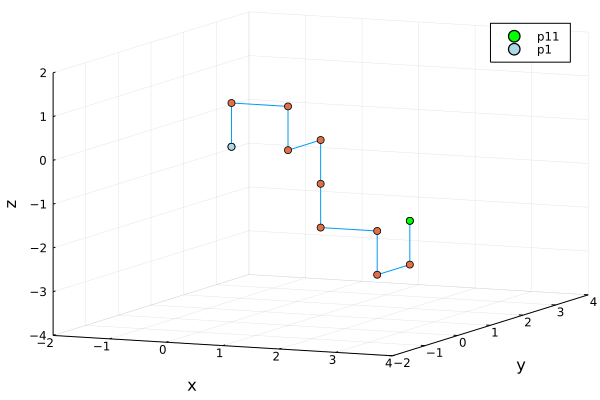

In [51]:
#Misc testing

#Random.seed!(345)
dirs,coordArr,coordSet = genRandWalk(10)
#dirs,coordArr,coordSet = genStrWalk(10)

#dirs = [2,6,3,5,2,6,4]
#coordArr, coordSet = dirToCoords(dirs)
#makeARebridge!(coordArr,coordSet,dirs,0)
#makeARebridge!(coordArr,coordSet,dirs,0)
#makeARebridge!(coordArr,coordSet,dirs,0)

visualise(coordArr)
#savefig("goodExReb3-1.png")
#println(energySum(dirs,coordArr))
#visualise(coordArr)
#savefig("goodExReb3-2.png")
#testMoves(9,-100)


In [52]:
#Misc testing pt 2

#Random.seed!(73)
#dirs,coordArr,coordSet = genRandWalk(11)
#dirs = [5,1,6,1,3,1,5]
#coordArr, coordSet = dirToCoords(dirs)
#println(rebridgeFindVertices(coordArr,coordSet,dirs,9,3))
#rebridge2Step!(coordArr,2,7,6,7,2)
#rebridgeEnd!(coordArr,coordSet,12,(0,0,1))
#pullEnd!(coordArr,coordSet,12,(0,0,-1),(1,0,-1))
#dirs = coordsToDir(coordArr)
#makeARebridge!(coordArr,coordSet,dirs)
#println(madrasInv!(coordArr,coordSet,dirs,4,4))
#makeAMadras!(coordArr,coordSet,dirs)
#ltPermute!(coordArr,coordSet,dirs,8,11,1)
#makeALT!(coordArr,coordSet,dirs)
#savefig("MCMCDemo1.png")
savefig("MCMCDemo1.png")
for i = 2:10
    
    makeALT!(coordArr,coordSet,dirs,0)
    visualise(coordArr)
    savefig("MCMCDemo$(i).png")
end

β = -50
β = -40
β = -30
β = -20
β = -10
β = 0
β = 10
β = 20
β = 30
β = 40
β = 50
β = 60
β = 70
β = 80
β = 90
β = 100


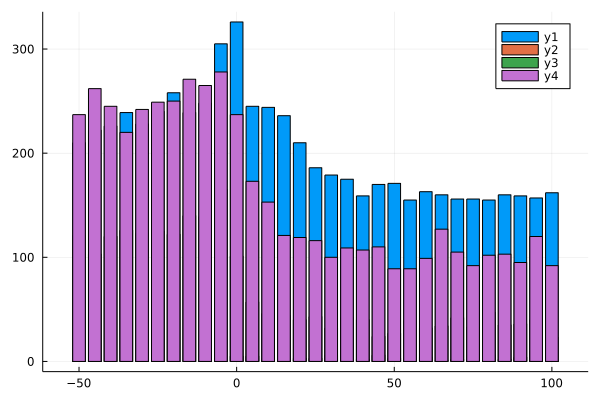

In [130]:
#Perform a series of trials with varying β value

#Random.seed!(182334)
gr()
len = 50
dirs,coordArr,coordSet = genStrWalk(len)
avgs = []
outcomes = [[],[],[],[]]
for beta = -50:5:100
    if (beta%10)==0
        println("β = $(beta)")
    end
    avg1,dirs,coordArr,coordSet,outs = testMoves(dirs,coordArr,coordSet,beta)
    push!(avgs,avg1)
    #testMoves(len,beta)
    #println()
    #savefig("LTMad_$(beta).png")
    push!(outcomes[1],outs[1,1])
    push!(outcomes[2],outs[2,1])
    push!(outcomes[3],outs[3,1])
    push!(outcomes[4],outs[4,1])
end
#io = open("LT$(len).txt","w")    #Save results to text file
#write(io,"Created by Max Figura, 2022/06/14\n Average energy for LT moves applied on SAWs of length $(len)\nβ=-50 to β=100, Δβ=0.5\n0 - 10,000 - 200,000\n\n")
#for i in avgs
#    write(io,"$(i)\n")
#end
#close(io)

#plot(-100:0.5:100,avgs,seriestype = :scatter,markersize=1,label="",xguide="β",yguide="Average Energy",xflip=true)

In [19]:
#Test SA algorithms

gr()
len = 50

#energies1,minConfig1,outcomes1 = basicSA(len)
#io = open("mintestExp$(len).txt","w")    #Save results to text file
#write(io,"Created by Max Figura, 2022/06/22\n Energy values for a minimisation trial with SAWs of length $(len)\nc = 0.1\n500,000 iterations, step every 50,000 iterations\nMinimum configuration of $(minConfig1) found\n")
#for i in energies1
#    write(io,"$(i)\n")
#end
#close(io)
#println(energies1[end])
#plot(0:(length(energies1)-1),energies1,label="",xguide="Iterations",yguide="Energy")
#println()

energies2,minConfig2,betas2 = thermodynamicSA(len)
#io = open("mintestTSA$(len).txt","w")    #Save results to text file
#write(io,"Created by Max Figura, 2022/06/22\n Energy values for a minimisation trial with SAWs of length $(len)\nkA = 0.002\n500,000 iterations\nMinimum configuration of $(minConfig2) found\n")
#for i in energies2
#    write(io,"$(i)\n")
#end
#close(io)
println(energies2[end])

plot(0:(length(energies2)-1),energies2,label="",xguide="Iterations",yguide="Energy")

β = 2.09310846936693e-5
β = 3.5250006500406295e-5
β = 4.9898945706500214e-5
β = 8.438041105993501e-5
β = 0.0001296260007950889
β = 0.00019870278535359252
β = 0.0003051715637924684
β = 0.00048630559335323257


LoadError: [91mInterruptException:[39m

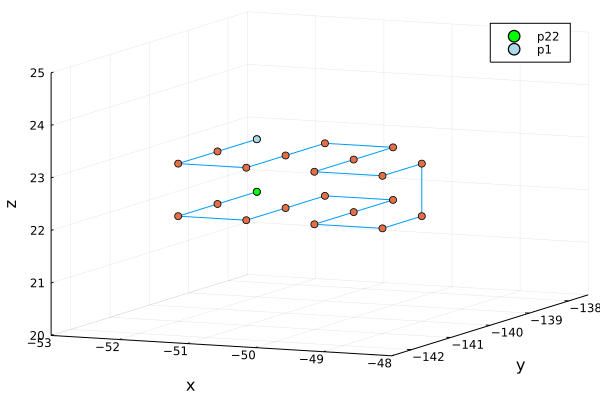

In [27]:
#plot(1:(length(outcomes2[1])),outcomes2,layout=(4,1),label="",xguide="Iterations",yguide="",title=["Pull" "LT" "Rebridge" "Madras"])
visualise(minConfig2)

In [64]:
#println(betas2[end-10:end])
plot(1:length(betas2),betas2,label="",xguide="Iterations",yguide="β (log scale)",yscale=:log10,ylims=(0.0001,1000))
savefig("betaCurve.png")

In [107]:
#Average Energy - β plotting
cList = palette(:tab10)    #For consistency in coloring
paths = ("LT_Energies/LT","Pull_Move_Energies/pulls","LT_Rebridge_Energies/LTReb","Pull_Rebridge_Energies/pullReb","LT_Madras_Energies/LTMad","Pull_Madras_Energies/pullMad")
titles =("LT Moves","Pull Moves","LT & Rebridges","Pulls & Rebridges","LT & Madras","Pulls & Madras")
errplots = []

gr()

calcLines = readlines("Energy_Values/Exact_Energies/E3.txt")[6:406]    #Exact values to compare
calcVal = []
for i = 1:401
    push!(calcVal,parse(Float64, calcLines[i]))
end
p1 = plot(-100:0.5:100,calcVal,label="",xguide="β",yguide="Average Energy",xflip=true,markerstrokewidth=0,seriescolor=cList[1])

compLines = readlines("Energy_Values/$(paths[2])3.txt")[6:406]    #Simulation-computed values
compVal = []
for i = 1:401
    push!(compVal,parse(Float64, compLines[i]))
end
plot!(p1,-100:0.5:100,compVal,seriestype = :scatter,markersize=2,label="N=3",xflip=true,markerstrokewidth=0,legend_position=:left,size=(600,400),seriescolor=cList[1])

#err = []    #Error tracking
#for i = 2:400
#    push!(err,(compVal[i]-calcVal[i])/(calcVal[i-1]-calcVal[i+1]))
#end
#push!(errplots,plot(-99.5:0.5:99.5,err,label="",xguide="β",yguide="Energy Error",xflip=true,seriescolor=cList[2],title=titles[1]))

for j = 4:9    #Showing a multitude of plots at once
    calcLines = readlines("Energy_Values/Exact_Energies/E$(j).txt")[6:406]
    calcVal = []
    for i = 1:401
        push!(calcVal,parse(Float64, calcLines[i]))
    end
    plot!(p1,-100:0.5:100,calcVal,label="",xguide="β",yguide="Average Energy",xflip=true,markerstrokewidth=0,seriescolor=cList[j-2])

    compLines = readlines("Energy_Values/$(paths[2])$(j).txt")[6:406]
    compVal = []
    for i = 1:401
        push!(compVal,parse(Float64, compLines[i]))
    end
    plot!(p1,-100:0.5:100,compVal,seriestype = :scatter,markersize=2,label="N=$(j)",markerstrokewidth=0,legend_position=:left,size=(600,400),seriescolor=cList[j-2])

    #err = []
    #for i = 2:400
    #    push!(err,(compVal[i]-calcVal[i])/(calcVal[i-1]-calcVal[i+1]))
    #end
    #plot!(p2,-100:0.5:100,err,label="",xflip=true,seriescolor=cList[j-2])
    #push!(errplots,plot(-99.5:0.5:99.5,err,label="",xguide="β",yguide="Energy Error",xflip=true,seriescolor=cList[2],title=titles[j]))
end

plot(p1,xguide="β",yguide="Average Energy",title=titles[2])
#plot(p1,p2,layout=grid(2,1,heights=[0.7,0.3]),size=(600,600))
#plot(errplots[1],errplots[2],errplots[3],errplots[4],errplots[5],errplots[6],layout=(3,2),size=(600,600),link=:all)#,plot_title="Absolute Error for N=9")
savefig("pullsEnergy1s.png")

-4.489772412312051
[(0, 0, 0), (0, 1, 0), (-1, 1, 0), (-1, 0, 0), (-2, 0, 0), (-2, 1, 0), (-3, 1, 0), (-3, 2, 0), (-2, 2, 0), (-2, 3, 0), (-2, 3, -1), (-2, 2, -1), (-3, 2, -1), (-3, 1, -1), (-2, 1, -1), (-2, 0, -1), (-1, 0, -1), (-1, 1, -1), (-1, 1, -2), (-1, 0, -2), (-2, 0, -2), (-2, 1, -2), (-3, 1, -2), (-3, 2, -2), (-2, 2, -2), (-2, 3, -2), (-2, 3, -3), (-2, 2, -3), (-3, 2, -3), (-3, 1, -3), (-2, 1, -3), (-2, 0, -3), (-1, 0, -3), (-1, 1, -3), (-1, 1, -4), (-2, 1, -4), (-2, 2, -4), (-1, 2, -4), (-1, 2, -3), (-1, 3, -3), (-1, 3, -2), (-1, 2, -2), (-1, 2, -1), (-1, 3, -1), (-1, 3, 0), (-1, 2, 0), (0, 2, 0), (0, 3, 0), (0, 3, -1), (0, 2, -1), (0, 2, -2), (0, 3, -2), (0, 3, -3), (0, 2, -3), (0, 2, -4), (1, 2, -4), (1, 1, -4), (0, 1, -4), (0, 1, -3), (0, 0, -3), (1, 0, -3), (1, 1, -3), (2, 1, -3), (2, 2, -3), (1, 2, -3), (1, 3, -3), (1, 3, -2), (1, 2, -2), (2, 2, -2), (2, 1, -2), (1, 1, -2), (1, 0, -2), (0, 0, -2), (0, 1, -2), (0, 1, -1), (0, 0, -1), (1, 0, -1), (1, 1, -1), (2, 1, -1), (2

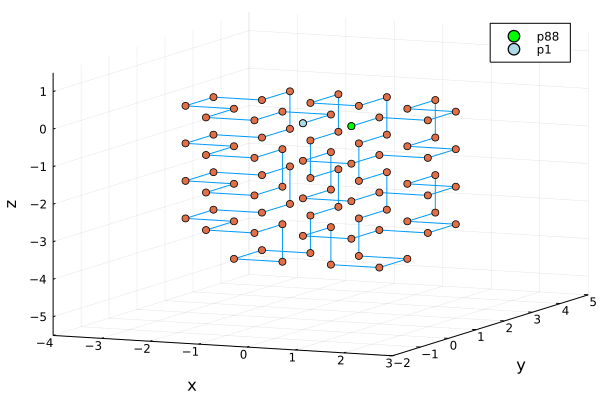

In [43]:
SAW = [(577, -454, 203), (577, -453, 203), (576, -453, 203), (576, -454, 203), (575, -454, 203), (575, -453, 203), (574, -453, 203), (574, -452, 203), (575, -452, 203), (575, -451, 203), (575, -451, 202), (575, -452, 202), (574, -452, 202), (574, -453, 202), (575, -453, 202), (575, -454, 202), (576, -454, 202), (576, -453, 202), (576, -453, 201), (576, -454, 201), (575, -454, 201), (575, -453, 201), (574, -453, 201), (574, -452, 201), (575, -452, 201), (575, -451, 201), (575, -451, 200), (575, -452, 200), (574, -452, 200), (574, -453, 200), (575, -453, 200), (575, -454, 200), (576, -454, 200), (576, -453, 200), (576, -453, 199), (575, -453, 199), (575, -452, 199), (576, -452, 199), (576, -452, 200), (576, -451, 200), (576, -451, 201), (576, -452, 201), (576, -452, 202), (576, -451, 202), (576, -451, 203), (576, -452, 203), (577, -452, 203), (577, -451, 203), (577, -451, 202), (577, -452, 202), (577, -452, 201), (577, -451, 201), (577, -451, 200), (577, -452, 200), (577, -452, 199), (578, -452, 199), (578, -453, 199), (577, -453, 199), (577, -453, 200), (577, -454, 200), (578, -454, 200), (578, -453, 200), (579, -453, 200), (579, -452, 200), (578, -452, 200), (578, -451, 200), (578, -451, 201), (578, -452, 201), (579, -452, 201), (579, -453, 201), (578, -453, 201), (578, -454, 201), (577, -454, 201), (577, -453, 201), (577, -453, 202), (577, -454, 202), (578, -454, 202), (578, -453, 202), (579, -453, 202), (579, -452, 202), (578, -452, 202), (578, -451, 202), (578, -451, 203), (578, -452, 203), (579, -452, 203), (579, -453, 203), (578, -453, 203), (578, -454, 203)]
#reverse!(SAW)
for i = 1:length(SAW)
    #SAW[i] = (-SAW[i][3],-SAW[i][2],-SAW[i][1])
end
dirs = coordsToDir(SAW)
#dirs = [2, 3, 1, 3, 5, 5, 1, 6, 6, 4, 1, 3, 5, 5, 1, 6, 6, 4, 5, 5, 2, 6, 2, 5, 2, 6, 2, 4, 1, 5, 1, 6, 1, 5, 1, 6, 6, 4, 5, 5, 2, 6, 6, 3, 2, 4, 5, 5, 2, 6]
#println(dirs)
SAW = dirToCoords(dirs)[1]
println(energySum(dirs,SAW))
println(SAW)
visualise(SAW)

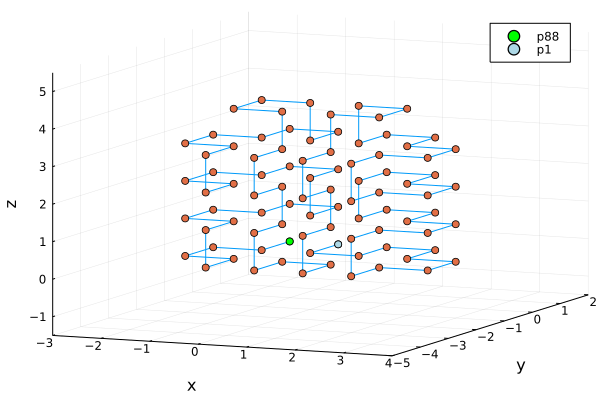

In [38]:
SAW = [(0, 0, 0), (0, -1, 0), (1, -1, 0), (1, 0, 0), (2, 0, 0), (2, -1, 0), (3, -1, 0), (3, -2, 0), (2, -2, 0), (2, -3, 0), (2, -3, 1), (2, -2, 1), (3, -2, 1), (3, -1, 1), (2, -1, 1), (2, 0, 1), (1, 0, 1), (1, -1, 1), (1, -1, 2), (1, 0, 2), (2, 0, 2), (2, -1, 2), (3, -1, 2), (3, -2, 2), (2, -2, 2), (2, -3, 2), (2, -3, 3), (2, -2, 3), (3, -2, 3), (3, -1, 3), (2, -1, 3), (2, 0, 3), (1, 0, 3), (1, -1, 3), (1, -1, 4), (2, -1, 4), (2, -2, 4), (1, -2, 4), (1, -2, 3), (1, -3, 3), (1, -3, 2), (1, -2, 2), (1, -2, 1), (1, -3, 1), (1, -3, 0), (1, -2, 0), (0, -2, 0), (0, -3, 0), (0, -3, 1), (0, -2, 1), (0, -2, 2), (0, -3, 2), (0, -3, 3), (0, -2, 3), (0, -2, 4), (-1, -2, 4), (-1, -1, 4), (0, -1, 4), (0, -1, 3), (0, 0, 3), (-1, 0, 3), (-1, -1, 3), (-2, -1, 3), (-2, -2, 3), (-1, -2, 3), (-1, -3, 3), (-1, -3, 2), (-1, -2, 2), (-2, -2, 2), (-2, -1, 2), (-1, -1, 2), (-1, 0, 2), (0, 0, 2), (0, -1, 2), (0, -1, 1), (0, 0, 1), (-1, 0, 1), (-1, -1, 1), (-2, -1, 1), (-2, -2, 1), (-1, -2, 1), (-1, -3, 1), (-1, -3, 0), (-1, -2, 0), (-2, -2, 0), (-2, -1, 0), (-1, -1, 0), (-1, 0, 0)]
visualise(SAW)
#savefig("min$(length(SAW)-1).png")

-1.3119434059376638
[(0, 0, 0), (0, 0, 1), (0, -1, 1), (0, -1, 0), (0, -2, 0), (-1, -2, 0), (-1, -1, 0), (-1, -1, 1), (-1, 0, 1), (-1, 0, 0), (-2, 0, 0), (-2, 0, 1), (-2, -1, 1), (-2, -1, 0), (-2, -2, 0), (-2, -2, -1), (-2, -1, -1), (-2, -1, -2), (-2, 0, -2), (-2, 0, -1), (-1, 0, -1), (-1, 0, -2), (-1, -1, -2), (-1, -1, -1), (-1, -2, -1), (0, -2, -1), (0, -1, -1), (0, -1, -2), (0, 0, -2), (0, 0, -1)]


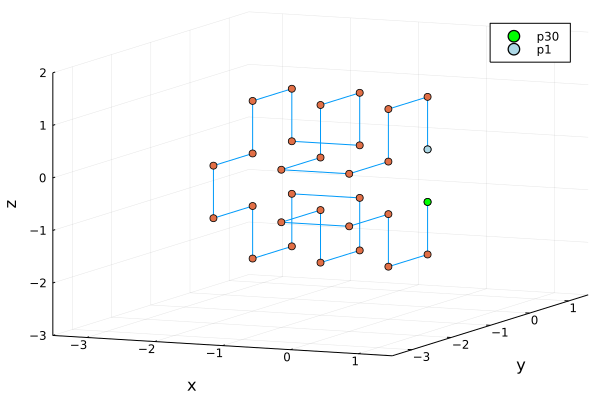

In [34]:
dirs = [5,4,6,4,2,3,5,3,6,2,5,4,6,4,6,3,6,3,5,1,6,4,5,4,1,3,6,3,5]
SAW = dirToCoords(dirs)[1]
println(energySum(dirs,SAW))
println(SAW)
visualise(SAW)

In [21]:
known = [-0.07957747155, -0.07957747155, -0.1591549431, -0.1824626449, -0.2853478182, -0.2750221231, -0.3442738995, -0.3875314103, -0.4620655574, -0.4670786295, -0.5529799716, -0.5686839855, -0.6448076162, -0.6661439293, -0.7304337399, -0.7668613829, -0.8462276571, -0.8677805876, -0.9327146275]
plot(3:21,known,seriestype = :scatter,label="Known Values",markersize=3,markerstrokewidth=0,xguide="Length of SAW",yguide="Minimum Energy",ylims=(-5,0))

pred = []
linTren = []
logTren = []
for i = 3:90
    push!(pred,(-0.612418*i + 1.19011)/(4*pi))
    push!(linTren,-0.0530462*i + 0.180362)
    push!(logTren,(-0.0336443*i + -0.00410912*i*log(i) + 0.0440087))
end
#plot!(3:90,pred,label="Predicted",linewidth=2)

minLines = readlines("tempmins.txt")
mins = []
for i in minLines
    push!(mins,parse(Float64, i))
end
plot!(3:90,mins,seriestype = :scatter,label="Lowest Found",markersize=3,markerstrokewidth=0)

plot!(3:90,linTren,label="New Trend\n(Linear, r²=0.9994)",linewidth=2)
plot!(3:90,logTren,label="New Trend\n(Logarithmic, R²=0.9999)",linewidth=2)

savefig("newMinima4.png")

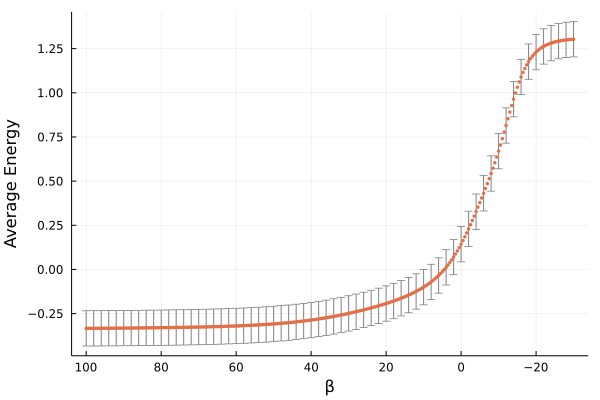

In [115]:
gr()
testbars = repeat([.1],261)
calcLines = readlines("Energy_Values/Exact_Energies/E9.txt")[6:406]    #Exact values to compare
calcVal = []
for i = 141:401
    push!(calcVal,parse(Float64, calcLines[i]))
end
plot(-30:2:100,calcVal[1:4:261],yerror=testbars,label="",xguide="β",yguide="Average Energy",xflip=true,markerstrokewidth=1,linewidth=0,markerstrokecolor="grey")
plot!(-30:0.5:100,calcVal,label="",xflip=true,seriestype=:scatter,markerstrokewidth=0,markersize=2)

In [34]:
a = [749, 769, 780, 751, 839, 886, 740, 788, 803, 791, 812, 1040, 807, 878, 783, 842, 826, 1164, 963, 1395, 1749, 1735, 1959, 2209, 1957, 2753, 1942, 1817, 2408, 5836, 3369, 6764, 7046, 6999, 9878, 10762, 14524, 17593, 21097, 27182, 39834, 46618, 49124, 69410, 91356, 109013, 136162, 158339, 188579, 215634, 237146, 257673, 278528, 291063, 304235, 313007, 319376, 322477, 325176, 326580, 328547, 322271, 315952, 309160, 301691, 293652, 287670, 279823, 274025, 264313, 258459, 250533, 244142, 238933, 231590, 224247, 218420, 212373, 206497, 201814, 196009, 190662, 184897, 179995, 174443, 169835, 166510, 161978, 157313, 153536, 150328, 145585, 141424, 137464, 134424, 130790, 126613, 122060, 120007, 116870, 112943, 109800, 107772, 104489, 101539, 99358, 96573, 93467, 90931, 88187, 86627, 85023, 80801, 78581, 77679, 74130, 72319, 70370, 68522, 67099, 64320, 63035, 60179, 59073, 58379, 56019, 54379, 54251, 51315, 49229, 49038, 48189, 46258, 45355, 43721, 42370, 41481, 40386, 39590, 37141, 37062, 35536, 35920, 34336, 32843, 31574, 31493, 29929, 29810, 28059, 27418, 27011, 26350, 25644, 24309, 24426, 23475, 22122, 21798, 20858, 20773, 19431, 19658, 18751, 18455, 18222, 16954, 16675, 16324, 15965, 15667, 15522, 13974, 13933, 14063, 13464, 12980, 12661, 12190, 11471, 11811, 11199, 11418, 10855, 10173, 9892, 9416, 9764, 9398, 8475, 8494, 8338, 8381, 7969, 7764, 7314, 6955, 7522, 7364, 6754, 6415, 5598, 5545, 5708, 5909, 5940, 5484, 5645, 5294, 4817, 4977, 4370, 4499, 5032, 3666, 3842, 4043, 4017, 3869, 4119, 3016, 3948, 3256, 3961, 2838, 3906, 2959, 2776, 2920, 2806, 2655, 2800, 2891, 2329, 2563, 2215, 2947, 2036, 3045, 2524, 2947, 2221, 1795, 2110, 1451, 2249, 2183, 1892, 1457, 1977, 1492, 1776, 1488, 1858, 1279, 1693, 1480, 935, 1126, 1788, 1202]
b = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 3, 2, 6, 12, 20, 39, 75, 119, 176, 235, 422, 581, 808, 1056, 1368, 1815, 2185, 2661, 3250, 3270, 3511, 3693, 3727, 4045, 3942, 4108, 4274, 4357, 4316, 4297, 4267, 4376, 4277, 4323, 4420, 4309, 4310, 4281, 4251, 4252, 4288, 4238, 4205, 4327, 4198, 4183, 4282, 4149, 4172, 4190, 4308, 4220, 4059, 4173, 4150, 4328, 4255, 4163, 4188, 4322, 4096, 4166, 4233, 4198, 4092, 4265, 4199, 4296, 4384, 4273, 4383, 4410, 4322, 4355, 4495, 4608, 4480, 4454, 4572, 4633, 4669, 4501, 4605, 4783, 4658, 4651, 4636, 4851, 4758, 4830, 4891, 4775, 5056, 4965, 5056, 4865, 4940, 5139, 5094, 5022, 5111, 5096, 4942, 5108, 5183, 5200, 5279, 5224, 5216, 5438, 5348, 5224, 5319, 5323, 5380, 5356, 5249, 5500, 5426, 5563, 5443, 5566, 5564, 5446, 5397, 5599, 5603, 5518, 5671, 5531, 5715, 5699, 5533, 5667, 5746, 5657, 5620, 5542, 5555, 5675, 5557, 5728, 5609, 5611, 5876, 5757, 5651, 5841, 5760, 5792, 5717, 5790, 5833, 5801, 5810, 5610, 5459, 5735, 5673, 5865, 5686, 5660, 5676, 5671, 5695, 5794, 5633, 5629, 5560, 5535, 5659, 5754, 5879, 5663, 5681, 5509, 5777, 5529, 5727, 5410, 5714, 5691, 5321, 5344, 5803, 5559, 5764, 5473, 5500, 5404, 5538, 5528, 5151, 5757, 5346, 5630, 5462, 5414, 5396, 5564, 5514, 5276, 5506, 5561, 5610, 5600, 5813, 5453, 5556, 5332, 5619, 5128, 5679, 5335, 5313, 5473, 5374, 5392, 5374]
#c = 
#d = 
gr()
plot(-30:0.5:100,a,xflip=true,label="Pulls",legend_position=:left,xguide="β",yguide="Successful Moves",title="Pulls & Rebridges")
plot!(-30:0.5:100,b,xflip=true,label="Rebridges")
#plot!(-30:0.5:100,c,xflip=true,label="Madras")
#plot!(-30:0.5:100,d,xflip=true,label="LT")
#savefig("PullReb50successRate.png")